In [2]:
import numpy as np
from itertools import product

class AMModel(object):
    '''
       AM model based on Experiment 2 KTH, SR, AM SPI Mechanism
    
    '''
    def __init__(self, **kwargs):
        
        self.numPlayers = 2
        self.value = np.array([200, 250, 320])
        self.cost = np.array([130, 80, 10])
        
        self.eps = kwargs.get('eps', 0.01)        
        
        # number of individual actions
        self.numiActions = 27
        self.buyerActions = np.array(list(product([0, 1, 2], repeat=3)))
        self.sellerActions = np.array(list(product([0, 1, 2], repeat=3)))
        
        self.memory = kwargs.get('memory', 0)
        self.true_value_index = kwargs.get('true_value',2)
        self.true_cost_index = kwargs.get('true_cost',2)
        self.trueValue = self.value[self.true_value_index]
        self.trueCost = self.cost[self.true_cost_index]
        
        self.reward = 300
        
        self.buyerInvestment = 0
        self.sellerInvestment = 0       
#         self.trueValue = self.init_TrueValue(self.sellerInvestment)
#         self.trueCost = self.init_TrueCost(self.buyerInvestment)
        
        
        self.numActions = self.numiActions ** self.numPlayers
        self.numStates = self.numiActions ** (self.numPlayers * self.memory)
        
        self.indexActions = self.init_indexActions()
        self.Prices = self.init_Prices()
        self.Profits,self.Penalty = self.init_Profits()

        # QL
        self.delta = kwargs.get('delta', 0.95)
        self.alpha = kwargs.get('alpha', 0.15) * np.ones(self.numPlayers)
        self.beta = kwargs.get('beta', 0.0005) * np.ones(self.numPlayers)
        
        self.lengthStates = self.numPlayers * self.memory
        self.lengthStrategies = self.numPlayers * self.numStates
        
        self.Q = self.init_Q()

        self.cActions = self.init_cActions()
        
        
    def init_indexActions(self):
        
        indexActions = []
        for i in range(self.numActions):
            
            indexActions.append(self.convertNumberBase(i, self.numiActions, self.numPlayers))
            
        indexActions = np.array(indexActions)
        
        return indexActions

    def init_TrueValue(self, i):
        if i == 0:
            return 200
        elif i == 25:
            return 250
        else:
            return 320

    def init_TrueCost(self, i):
        if i == 0:
            return 130
        elif i == 25:
            return 80
        else:
            return 10
    
    def init_Prices(self):
        
        pricesArray = np.zeros((3, 3))
        for cb in range(0, 3):
            for vs in range(0, 3):
                
                # (vs-200) - (130-cb) + 165
                
                pricesArray[cb][vs] = (self.value[vs] - 200) - (130 - self.cost[cb]) + 165
                
        return pricesArray

    
    def init_Profits(self):
        Profits = np.zeros((2, self.numActions, self.numPlayers))
        Actions = np.zeros((self.numActions, 6))
        
        Penalty = np.zeros((2, self.numActions, self.numPlayers))
        
        for i in range(self.numActions):
            
            b = int(self.indexActions[i][0])
            s = int(self.indexActions[i][1])
            
            vb, cb, vb_a = self.buyerActions[b]
            vs, cs, cs_a = self.sellerActions[s]
            penalb = 0
            penals = 0
            
            Actions[i] = vb, cb, vb_a, vs, cs, cs_a

            pb_na = self.trueValue - self.Prices[cb][vs] - self.buyerInvestment

            # profit for seller: price - true cost - investment_seller
            ps_na = self.Prices[cb][vs] - self.trueCost - self.sellerInvestment
            
            Profits[0][i] = [pb_na, ps_na]
            Penalty[0][i] = [penalb,penals]

            
            if (vb == vs) and (cb == cs):
                # if all report coincide
                
                # profit for buyer: true value - price - investment_buyer
                pb = self.trueValue - self.Prices[cb][vs] - self.buyerInvestment
                
                # profit for seller: price - true cost - investment_seller
                ps = self.Prices[cb][vs] - self.trueCost - self.sellerInvestment               
                
            elif (vb != vs) and (cb == cs):
                # only the value reports differ
                # buyer enters into arbitration stage
                
                if vb_a == 0:
                    # no_trade
                    pb = 0 - self.buyerInvestment
                    ps = 0 - self.sellerInvestment
                    
                elif vb_a == 1:
                    pb = 0.5 * 0 + 0.5 * (self.trueValue - 205) - self.buyerInvestment
                    ps = 0.5 * 0 + 0.5 * (205 - self.trueCost) - self.sellerInvestment
                    
                else:
                    pb = 0.5 * (self.trueValue - 205) + 0.5 * (self.trueValue - 255) - self.buyerInvestment
                    ps = 0.5 * (255 - self.trueCost) + 0.5 * (205 - self.trueCost) - self.sellerInvestment

                # buyers is fined 300
                pb = pb - 300
                penalb = -300
                # the seller is rewarded a bonus of 300 if the second report of 
                # the buyer matches the first stage report
                # of seller. In other cases, the seller is also fined 300.
                
                
                if vb_a == vs:
                    ps = ps + self.reward
                    penals = self.reward
                    
                else:
                    ps = ps - 300
                    penals = -300
                    
            elif (vb == vs) and (cb != cs):
                # only the cost reports differ
                # seller enters into arbitration stage
                
                if cs_a == 0:
                    # no_trade
                    pb = 0 - self.buyerInvestment
                    ps = 0 - self.sellerInvestment
                    
                elif cs_a == 1:
                    pb = 0.5 * 0 + 0.5 * (self.trueValue - 125) - self.buyerInvestment
                    ps = 0.5 * 0 + 0.5 * (125 - self.trueCost) - self.sellerInvestment
                    
                else:
                    pb = 0.5 * (self.trueValue - 125) + 0.5 * (self.trueValue - 75) - self.buyerInvestment
                    ps = 0.5 * (125 - self.trueCost) + 0.5 * (75 - self.trueCost) - self.sellerInvestment

                # seller is fined 300
                ps = ps - 300
                penals = -300
                # the buyer is rewarded a bonus of 300 if the second report of 
                # the seller matches the first stage report
                # of buyer. In other cases, the buyer is also fined 300.
                
                if cs_a == cb:
                    pb = pb + self.reward
                    penalb = self.reward
                    
                else:
                    pb = pb - 300
                    penalb = -300
                    
            else:
                if vb_a == 0:
                    # no_trade
                    pb1 = 0 - self.buyerInvestment
                    ps1 = 0 - self.sellerInvestment
                    
                elif vb_a == 1:
                    pb1 = 0.5 * 0 + 0.5 * (self.trueValue - 205) - self.buyerInvestment
                    ps1 = 0.5 * 0 + 0.5 * (205 - self.trueCost) - self.sellerInvestment
                    
                else:
                    pb1 = 0.5 * (self.trueValue - 205) + 0.5 * (self.trueValue - 255) - self.buyerInvestment
                    ps1 = 0.5 * (255 - self.trueCost) + 0.5 * (205 - self.trueCost) - self.sellerInvestment
                    
                if vb_a == vs:
                    ps1 = ps1 + self.reward
                    penals = self.reward

                if cs_a == 0:
                    # no_trade
                    pb2 = 0 - self.buyerInvestment
                    ps2 = 0 - self.sellerInvestment
                    
                elif cs_a == 1:
                    pb2 = 0.5 * 0 + 0.5 * (self.trueValue - 125) - self.buyerInvestment
                    ps2 = 0.5 * 0 + 0.5 * (125 - self.trueCost) - self.sellerInvestment
                    
                else:
                    pb2 = 0.5 * (self.trueValue - 125) + 0.5 * (self.trueValue - 75) - self.buyerInvestment
                    ps2 = 0.5 * (125 - self.trueCost) + 0.5 * (75 - self.trueCost) - self.sellerInvestment
                    
                if cs_a == cb:
                    pb2 = pb2 + self.reward
                    penalb = self.reward

                pb = 0.5 * (pb1 + pb2) - 300 
                ps = 0.5 * (ps1 + ps2) - 300
                penalb = penalb -300
                penals = penals -300
                    

            Profits[1][i] = [pb, ps]
            Penalty[1][i] = [penalb,penals]
            

        return Profits,Penalty

    
    def init_Q(self):
        Q = np.zeros((self.numActions, self.numiActions, self.numPlayers))
        for iReport in range(self.numiActions):
            
            den = np.count_nonzero(self.indexActions == iReport,axis = 0,keepdims = True) * (1 - self.delta)
            Q[:, iReport,:] = np.ma.array((1 - self.eps)*self.Profits[0]+self.eps * self.Profits[1],
                                mask=(self.indexActions != iReport)).sum(axis = 0) / den
        return Q


    def init_cActions(self):
        """Initialize cActions (used for q-learning)"""
        
        x = np.arange(self.numPlayers - 1, -1, -1)
        cActions = self.numiActions ** x
        
        return cActions
    
    @staticmethod
    def convertNumberBase(n, b, l):
        '''
        Converts an integer n from base 10 to base b,
        generating a vector of integers of length l
        '''
        tmp = n
        ans = np.zeros(l)
        for i in range(1, l+1):
            ans[l-i] = int(tmp % b)
            tmp = np.floor(tmp/b)
        return ans



    

In [30]:
am = AMModel()
np.sum(am.Penalty>0),np.sum(am.Penalty<0)

(108, 972)

In [33]:
import numpy as np

# from AMModel import AMModel

    
class AM_Qlearning(object):
    '''
        Qlearning based on AM model
    '''
    def __init__(self, **kwargs):
        
        self.alpha = kwargs.get('alpha',0.25)
        self.beta = kwargs.get('beta',0.0005)
        self.eps = kwargs.get('eps',0.95)
        self.convergedtime = kwargs.get('convergedtime',500)
        self.numSessions = kwargs.get('numSessions',1)
        self.maxIters = kwargs.get('maxIters',14000)
        self.game = AMModel(alpha = self.alpha, beta = self.beta,eps = self.eps)
        self.initial_state = kwargs.get('initial_state',0)
        self.true_state = np.array([self.game.true_value_index,self.game.true_cost_index,\
                                    self.game.true_value_index])

        self.true_state_index = np.where((self.game.buyerActions == self.true_state).all(axis = 1))[0][0]


        
               
    def computePPrime(self, strategyPrime, iters):
        
        pPrime = np.zeros(self.game.numPlayers)
        #  Greedy with probability 1-epsilon, with exponentially decreasing epsilon
        
        for iPlayer in range(self.game.numPlayers):
            
            if np.random.uniform(0,1) < np.exp(-self.game.beta[iPlayer]*iters):

                pPrime[iPlayer] = np.floor(self.game.numiActions*np.random.uniform(0,1))
            else:
                pPrime[iPlayer] = strategyPrime[iPlayer]
                
        return pPrime


    def q_learning(self):
        # Initializing various quantities

        indexStrategies = np.zeros((self.game.numPlayers,self.numSessions))

        indexConverge = np.zeros((self.game.numPlayers,self.numSessions))
        
        self.profit_list = np.full((self.numSessions,self.maxIters,self.game.numPlayers),np.nan)
        self.penalty_list = np.full((self.numSessions,self.maxIters,self.game.numPlayers),np.nan)
        self.pure_list = np.full((self.numSessions,self.maxIters,self.game.numPlayers),np.nan)
        
        # Loop over numSessions
        for iSession in range(self.numSessions):
            
            
            # Learning Phase
            
            # Initialization
            self.Q = self.game.Q.copy()
            self.strategyPrime = np.zeros(self.game.numPlayers)
            maxVal = np.zeros(self.game.numPlayers)
            initialAction = np.floor(np.random.uniform(0,1,(2))*self.game.numiActions)   
            strategyPrime = initialAction
            
            indexs = 0
            # Loop
            itersInStrategy = 0
            convergedSession = -1
            
            strategyFix = np.zeros(self.game.numPlayers)
            
            for iters in range(self.maxIters):
                
                # Iterations counter

                # Compute pPrime by balancing exploration vs. exploitation

                pPrime = self.computePPrime(strategyPrime, iters)
                #pPrime = strategyPrime
                actionPrime = int(np.sum(self.game.cActions*pPrime)) 

                state = actionPrime
                state1 = int(np.sum(self.game.cActions*strategyPrime)) 

                
                for iPlayer in range(self.game.numPlayers):
                    
                    temp_q = self.Q[state,:,iPlayer]
                    maxVal[iPlayer] = np.max(temp_q)

                    strategyPrimeList = np.where(temp_q == maxVal[iPlayer])[0]
                    
                    u = np.random.uniform(0, 1)
                    strategyPrime[iPlayer] = strategyPrimeList[int(len(strategyPrimeList)*u)]
                    
                    # Q matrices and strategies update
                    oldq = self.Q[state, int(pPrime[iPlayer]), iPlayer]
                    
                    
                    if np.random.uniform(0, 1) < 1 - self.game.eps:
                        profits = self.game.Profits[0][state, iPlayer]
                        vb, cb, vb_a = self.game.buyerActions[int(pPrime[0])]
                        vs, cs, cs_a = self.game.sellerActions[int(pPrime[1])]
                        #if vb == vs and cb == cs:
                        if state == 728:
                            indexs+=1
                            self.profit_list[iSession,iters,iPlayer] = self.game.Profits[0][state,iPlayer]
                            self.penalty_list[iSession,iters,iPlayer] = self.game.Penalty[0][state,iPlayer]
                            self.pure_list[iSession,iters,iPlayer] = \
                                self.game.Profits[0][state,iPlayer] - self.game.Penalty[0][state,iPlayer]
                        else:
                            self.profit_list[iSession,iters,iPlayer] = 0
                            self.penalty_list[iSession,iters,iPlayer] = self.game.Penalty[0][state,iPlayer] 
                            self.pure_list[iSession,iters,iPlayer] = 0
                         
                        
                    else:
                        profits = self.game.Profits[1][state, iPlayer]
#                         self.profit_list[iSession,iters,iPlayer] = 0
#                         self.penalty_list[iSession,iters,iPlayer] = self.game.Penalty[1][state,iPlayer]
                        if state == 728:
                            self.profit_list[iSession,iters,iPlayer] = self.game.Profits[1][state,iPlayer]
                            self.penalty_list[iSession,iters,iPlayer] = self.game.Penalty[1][state,iPlayer]
                            self.pure_list[iSession,iters,iPlayer] = \
                                self.game.Profits[0][state,iPlayer] - self.game.Penalty[0][state,iPlayer]
                        else:
                            self.profit_list[iSession,iters,iPlayer] = 0
                            self.penalty_list[iSession,iters,iPlayer] = self.game.Penalty[1][state,iPlayer]
                            self.pure_list[iSession,iters,iPlayer] = 0
                        
                    newq = oldq + self.game.alpha[iPlayer] * (profits + \
                                                self.game.delta * maxVal[iPlayer] - oldq)
                    self.Q[state1, int(pPrime[iPlayer]), iPlayer] = newq

                # Assessing convergence
                if np.array_equiv(strategyPrime, pPrime):
                    itersInStrategy = itersInStrategy + 1
                
                else:
                    itersInStrategy = 1

                # Check for convergence in strategy
                if convergedSession == -1:
                    # Maximum number of iterations exceeded
                    if iters >= self.maxIters - 1:
                        convergedSession = 0


                    if itersInStrategy == self.convergedtime:
                        convergedSession = 1
                        self.converge_iterations = iters

                    strategyFix = strategyPrime.copy()               #testing

                # Check for loop exit criteria
                if convergedSession != -1:
                    pass

                # if no converge yet, update and iterate
    
            indexConverge[:,iSession] = (convergedSession, iters)
            indexStrategies[:,iSession] = strategyFix
            self.indexConverge = indexConverge
            self.indexStrategies = indexStrategies
            print(iSession,convergedSession)
            #print('//////////',indexs)

        return indexConverge, indexStrategies, self.converge_iterations



    

In [34]:
K = AM_Qlearning(eps = 0.9)
K.q_learning()


0 1


(array([[1.0000e+00],
        [1.3999e+04]]),
 array([[26.],
        [26.]]),
 11696)

0 1


Text(0.5, 1.0, 'penalty for AM94 model with eps = 0.5')

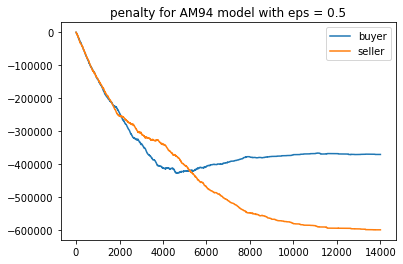

In [35]:
K = AM_Qlearning(eps = 0.9)
K.q_learning()
import matplotlib.pyplot as plt
plt.plot(K.penalty_list[0,:,0].cumsum())
plt.plot(K.penalty_list[0,:,1].cumsum())
plt.legend(labels=['buyer','seller'],loc='best')
plt.title('penalty for AM94 model with eps = 0.5')
#np.save('./experiment data/penalty_eps=09_reward=300.npy',K.penalty_list)


12055


Text(0.5, 1.0, 'profit-penalty for AM94 model with eps = 0.5')

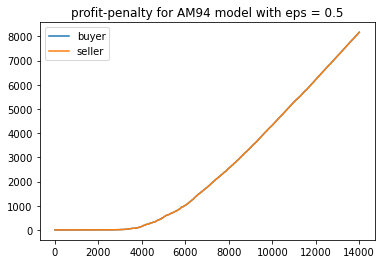

In [36]:
import matplotlib.pyplot as plt
plt.plot((K.pure_list[0,:,0].cumsum())/155)
plt.plot((K.pure_list[0,:,1].cumsum())/155)
plt.legend(labels=['buyer','seller'],loc='best')
print(K.converge_iterations)
plt.title('profit-penalty for AM94 model with eps = 0.5')
#np.save('./experiment data/implementation_eps=09_reward=300.npy',K.pure_list)

Text(0.5, 1.0, 'profit for AM94 model with eps = 0.4')

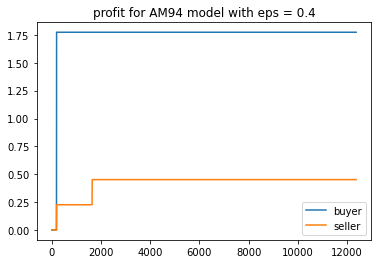

In [129]:
import matplotlib.pyplot as plt
plt.plot(K.profit_list[0,:,0].cumsum()/155)
plt.plot(K.profit_list[0,:,1].cumsum()/155)
plt.legend(labels=['buyer','seller'],loc='best')
plt.title('profit for AM94 model with eps = 0.4')

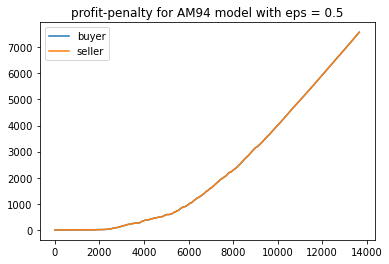

In [205]:
import matplotlib.pyplot as plt
plt.plot((K.pure_list[0,:,0].cumsum())/155)
plt.plot((K.pure_list[0,:,1].cumsum())/155)
plt.legend(labels=['buyer','seller'],loc='best')
plt.title('profit-penalty for AM94 model with eps = 0.5')
np.save('./experiment data/implementation_eps=09_reward=300.npy',K.pure_list)

In [14]:
np.sum(K.penalty_list[0,:int(K.indexConverge[1,0]),0]!=0)/ \
    (np.sum(~np.isnan(K.penalty_list[0,:int(K.indexConverge[1,0]),0]))-500)

0.09836065573770492

In [14]:
K.penality_list[:,0]

array([[   0.,    0.],
       [   0.,    0.],
       [   0.,    0.],
       [   0.,    0.],
       [   0.,    0.],
       [   0.,    0.],
       [   0., -300.],
       [   0.,    0.],
       [   0.,    0.],
       [   0.,    0.]])

In [23]:
from multiprocessing import Pool

def single_process(alpha):

    converge_list = [10000]
    beta_list = [0.0005]
    for cl in converge_list:
        df = pd.DataFrame(columns=['alpha','beta','total_sessions',
                                   'converged_times','i ndexStrategie','indexConverge'])
        path = 'SR_parallel_result'
        if not os.path.exists(path):
            os.mkdir(path)

        for beta in beta_list:
            temp_model = AM_Qlearning(alpha = alpha,beta = beta, convergedtime = cl)
            temo_model.q_learning()
            indexConverge,indexStrategies = q_learning()
            df = df.append({'alpha':alpha,'beta':beta,'total_sessions':kth.numSessions,
                            'converged_times':cl,'indexStrategie':indexStrategies,
                            'indexConverge':indexConverge },ignore_index=True)
            print('alpha:',alpha,' beta:',beta,' converged_times:',cl,' finish!')

        with open(path + '/' + 'a_'+ str(alpha) + 'b_'+ str(beta) + '_cl_' + str(cl) + '.pkl', 'wb') as f:
            pickle.dump(df, f)

def run_complex_operations(operation, input, pool):
    pool.map(operation, input)



In [614]:
# processes_count = 10
     

# alpha_list = np.linspace(0.025,0.25,2)
# processes_pool = Pool(processes_count)
# run_complex_operations(single_process,alpha_list , processes_pool)

In [250]:
dd = np.array(list(product([0, 1, 2], repeat=3)))

In [251]:
dd

array([[0, 0, 0],
       [0, 0, 1],
       [0, 0, 2],
       [0, 1, 0],
       [0, 1, 1],
       [0, 1, 2],
       [0, 2, 0],
       [0, 2, 1],
       [0, 2, 2],
       [1, 0, 0],
       [1, 0, 1],
       [1, 0, 2],
       [1, 1, 0],
       [1, 1, 1],
       [1, 1, 2],
       [1, 2, 0],
       [1, 2, 1],
       [1, 2, 2],
       [2, 0, 0],
       [2, 0, 1],
       [2, 0, 2],
       [2, 1, 0],
       [2, 1, 1],
       [2, 1, 2],
       [2, 2, 0],
       [2, 2, 1],
       [2, 2, 2]])

Text(0.5, 1.0, 'buyer penalty for AM94, AM and SR model')

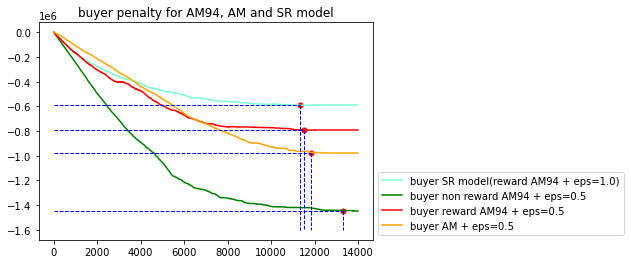

In [291]:
import matplotlib.pyplot as plt
ylreward = np.load('./experiment data/10reward.npy')
lwnoreward = np.load('./experiment data/05noreward.npy')
lwreward = np.load('./experiment data/05reward.npy')
lwam = np.load('./experiment data/penalty_eps=0.5_AM.npy')

plt.plot(ylreward[0,:,0].cumsum(),color = 'aquamarine')
indexes1 = np.where(~np.isnan(ylreward[0,:,0]))[0][-1] + 1

plt.plot(lwnoreward[0,:,0].cumsum(),color = 'green')
indexes2 = np.where(~np.isnan(lwnoreward[0,:,0]))[0][-1] + 1

plt.plot(lwreward[0,:,0].cumsum(),color = 'red')
indexes3 = np.where(~np.isnan(lwreward[0,:,0]))[0][-1] + 1

plt.plot(lwam[0,:,0].cumsum(),color = 'orange')
indexes4 = np.where(~np.isnan(lwam[0,:,0]))[0][-1] + 1

plt.scatter([indexes1-500],(ylreward[0,:,0].cumsum())[indexes1-500],s=25,c='r')
plt.plot([-0,indexes1-500],[(ylreward[0,:,0].cumsum())[indexes1-500],\
                            (ylreward[0,:,0].cumsum())[indexes1-500]],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1-500,indexes1-500],[(ylreward[0,:,0].cumsum())[indexes1-500],-1.6e6],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1,14000],[ylreward[0,:,0].cumsum()[indexes1-1],\
                           ylreward[0,:,0].cumsum()[indexes1-1]],c = 'aquamarine')


plt.scatter([indexes2-500],(lwnoreward[0,:,0].cumsum())[indexes2-500],s=25,c='r')
plt.plot([-0,indexes2-500],[(lwnoreward[0,:,0].cumsum())[indexes2-500],\
                            (lwnoreward[0,:,0].cumsum())[indexes2-500]],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes2-500,indexes2-500],[(lwnoreward[0,:,0].cumsum())[indexes2-500],-1.6e6],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes2,14000],[lwnoreward[0,:,0].cumsum()[indexes2-1],\
                           lwnoreward[0,:,0].cumsum()[indexes2-1]],c = 'green')


plt.scatter([indexes3-500],(lwreward[0,:,0].cumsum())[indexes3-500],s=25,c='r')
plt.plot([-0,indexes3-500],[(lwreward[0,:,0].cumsum())[indexes3-500],\
                            (lwreward[0,:,0].cumsum())[indexes3-500]],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes3-500,indexes3-500],[(lwreward[0,:,0].cumsum())[indexes3-500],-1.6e6],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes3,14000],[lwreward[0,:,0].cumsum()[indexes3-1],\
                           lwreward[0,:,0].cumsum()[indexes3-1]],c = 'red')

    

plt.scatter([indexes4-500],(lwam[0,:,0].cumsum())[indexes4-500],s=25,c='r')
plt.plot([-0,indexes4-500],[(lwam[0,:,0].cumsum())[indexes4-500],\
                            (lwam[0,:,0].cumsum())[indexes4-500]],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes4-500,indexes4-500],[(lwam[0,:,0].cumsum())[indexes4-500],-1.6e6],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes4,14000],[lwam[0,:,0].cumsum()[indexes4-1],\
                           lwam[0,:,0].cumsum()[indexes4-1]],c = 'orange')


plt.legend(labels=['buyer SR model(reward AM94 + eps=1.0)',
                   'buyer non reward AM94 + eps=0.5',
                   'buyer reward AM94 + eps=0.5',
                   'buyer AM + eps=0.5'],loc = 3,bbox_to_anchor = (1,0))
plt.title('buyer penalty for AM94, AM and SR model')


Text(0.5, 1.0, 'seller penalty for AM94, AM and SR model')

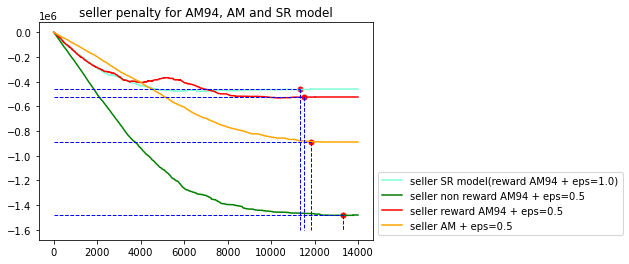

In [292]:
import matplotlib.pyplot as plt
ylreward = np.load('./experiment data/10reward.npy')
lwnoreward = np.load('./experiment data/05noreward.npy')
lwreward = np.load('./experiment data/05reward.npy')
lwam = np.load('./experiment data/penalty_eps=0.5_AM.npy')

plt.plot(ylreward[0,:,1].cumsum(),c = 'aquamarine')
indexes1 = np.where(~np.isnan(ylreward[0,:,1]))[0][-1] + 1

plt.plot(lwnoreward[0,:,1].cumsum(),c = 'green')
indexes2 = np.where(~np.isnan(lwnoreward[0,:,1]))[0][-1] + 1

plt.plot(lwreward[0,:,1].cumsum(),c = 'red')
indexes3 = np.where(~np.isnan(lwreward[0,:,1]))[0][-1] + 1

plt.plot(lwam[0,:,1].cumsum(),c = 'orange')
indexes4 = np.where(~np.isnan(lwam[0,:,1]))[0][-1] + 1

plt.scatter([indexes1-500],(ylreward[0,:,1].cumsum())[indexes1-500],s=25,c='r')
plt.plot([-0,indexes1-500],[(ylreward[0,:,1].cumsum())[indexes1-500],\
                            (ylreward[0,:,1].cumsum())[indexes1-500]],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1-500,indexes1-500],[(ylreward[0,:,1].cumsum())[indexes1-500],-1.6e6],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1,14000],[ylreward[0,:,1].cumsum()[indexes1-1],\
                           ylreward[0,:,1].cumsum()[indexes1-1]],c = 'aquamarine')


plt.scatter([indexes2-500],(lwnoreward[0,:,1].cumsum())[indexes2-500],s=25,c='r')
plt.plot([-0,indexes2-500],[(lwnoreward[0,:,1].cumsum())[indexes2-500],\
                            (lwnoreward[0,:,1].cumsum())[indexes2-500]],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes2-500,indexes2-500],[(lwnoreward[0,:,1].cumsum())[indexes2-500],-1.6e6],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes2,14000],[lwnoreward[0,:,1].cumsum()[indexes2-1],\
                           lwnoreward[0,:,1].cumsum()[indexes2-1]],c = 'green')


plt.scatter([indexes3-500],(lwreward[0,:,1].cumsum())[indexes3-500],s=25,c='r')
plt.plot([-0,indexes3-500],[(lwreward[0,:,1].cumsum())[indexes3-500],\
                            (lwreward[0,:,1].cumsum())[indexes3-500]],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes3-500,indexes3-500],[(lwreward[0,:,1].cumsum())[indexes3-500],-1.6e6],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes3,14000],[lwreward[0,:,1].cumsum()[indexes3-1],\
                           lwreward[0,:,1].cumsum()[indexes3-1]],c = 'red')



plt.scatter([indexes4-500],(lwam[0,:,1].cumsum())[indexes4-500],s=25,c='r')
plt.plot([-0,indexes4-500],[(lwam[0,:,1].cumsum())[indexes4-500],\
                            (lwam[0,:,1].cumsum())[indexes4-500]],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes4-500,indexes4-500],[(lwam[0,:,1].cumsum())[indexes4-500],-1.6e6],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes4,14000],[lwam[0,:,1].cumsum()[indexes4-1],\
                           lwam[0,:,1].cumsum()[indexes4-1]],c = 'orange')

plt.legend(labels=['seller SR model(reward AM94 + eps=1.0)',
                   'seller non reward AM94 + eps=0.5',
                   'seller reward AM94 + eps=0.5',
                   'seller AM + eps=0.5'],loc = 3,bbox_to_anchor = (1,0))
plt.title('seller penalty for AM94, AM and SR model')





Text(0.5, 1.0, 'buyer implementation for AM94, AM and SR model')

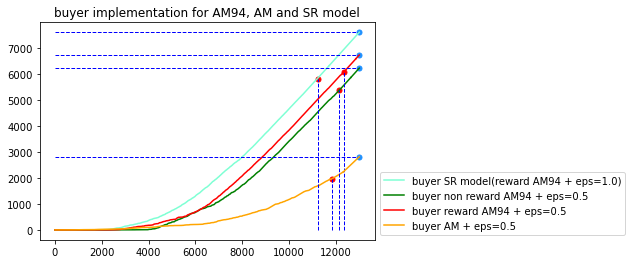

In [313]:
import matplotlib.pyplot as plt
ylreward = np.load('./experiment data/10reward_implementation.npy')/155
lwnoreward = np.load('./experiment data/05noreward_implementation.npy')/155
lwreward = np.load('./experiment data/05reward_implementation.npy')/155
lwam = np.load('./experiment data/implementation_eps=0.5_AM.npy')/155

player = 0

plt.plot(ylreward[0,:,player].cumsum(),c = 'aquamarine')
indexes1 = np.where(~np.isnan(ylreward[0,:,player]))[0][-1] + 1

plt.plot(lwnoreward[0,:,player].cumsum(),c = 'green')
indexes2 = np.where(~np.isnan(lwnoreward[0,:,player]))[0][-1] + 1

plt.plot(lwreward[0,:,player].cumsum(),c= 'red')
indexes3 = np.where(~np.isnan(lwreward[0,:,player]))[0][-1] + 1

plt.plot(lwam[0,:,player].cumsum(),c = 'orange')
indexes4 = np.where(~np.isnan(lwam[0,:,player]))[0][-1] + 1

plt.scatter([indexes1-500],(ylreward[0,:,player].cumsum())[indexes1-500],s=25,c='r')
plt.scatter([13000],(ylreward[0,:,player].cumsum())[indexes1-1]+13001-indexes1,s=25,c='dodgerblue')
plt.plot([-0,13000],[ylreward[0,:,player].cumsum()[indexes1-1]+13001-indexes1,\
                            ylreward[0,:,player].cumsum()[indexes1-1]+13001-indexes1],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1-500,indexes1-500],[0,(ylreward[0,:,player].cumsum())[indexes1-500]],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1-1,13000],[ylreward[0,:,player].cumsum()[indexes1-1],\
                           ylreward[0,:,player].cumsum()[indexes1-1]+13001-indexes1],c = 'aquamarine')


plt.scatter([indexes2-500],(lwnoreward[0,:,player].cumsum())[indexes2-500],s=25,c='r')
plt.scatter([13000],(lwnoreward[0,:,player].cumsum())[indexes2-1]+13001-indexes2,s=25,c='dodgerblue')
plt.plot([-0,13000],[(lwnoreward[0,:,player].cumsum())[indexes2-1]+13001-indexes2,\
                            (lwnoreward[0,:,player].cumsum())[indexes2-1]+13001-indexes2],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes2-500,indexes2-500],[0,(lwnoreward[0,:,player].cumsum())[indexes2-500]],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes2-1,13000],[lwnoreward[0,:,player].cumsum()[indexes2-1],\
                           lwnoreward[0,:,player].cumsum()[indexes2-1]+13001-indexes2],c = 'green')

plt.scatter([indexes3-500],(lwreward[0,:,player].cumsum())[indexes3-500],s=25,c='r')
plt.scatter([13000],(lwreward[0,:,player].cumsum())[indexes3-1]+13001-indexes3,s=25,c='dodgerblue')
plt.plot([-0,13000],[(lwreward[0,:,player].cumsum())[indexes3-1]+13001-indexes3,\
                            (lwreward[0,:,player].cumsum())[indexes3-1]+13001-indexes3],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes3-500,indexes3-500],[0,(lwreward[0,:,player].cumsum())[indexes3-500]],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes3-1,13000],[lwreward[0,:,player].cumsum()[indexes3-1],\
                           lwreward[0,:,player].cumsum()[indexes3-1]+13001-indexes3],c = 'red')

plt.scatter([indexes4-500],(lwam[0,:,player].cumsum())[indexes4-500],s=25,c='r')
plt.scatter([13000],(lwam[0,:,player].cumsum())[indexes4-1]+12901-indexes4,s=25,c='dodgerblue')
plt.plot([-0,13000],[(lwam[0,:,player].cumsum())[indexes4-1]+12901-indexes4,\
                            (lwam[0,:,player].cumsum())[indexes4-1]+12901-indexes4],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes4-500,indexes4-500],[0,(lwam[0,:,player].cumsum())[indexes4-500]],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes4-1,13000],[lwam[0,:,player].cumsum()[indexes4-1],\
                           lwam[0,:,player].cumsum()[indexes4-1]+12901-indexes4],c = 'orange')

plt.legend(labels=['buyer SR model(reward AM94 + eps=1.0)',
                   'buyer non reward AM94 + eps=0.5',
                   'buyer reward AM94 + eps=0.5',
                   'buyer AM + eps=0.5'],loc = 3,bbox_to_anchor = (1,0))
plt.title('buyer implementation for AM94, AM and SR model')




Text(0.5, 1.0, 'seller implementation for AM94, AM and SR model')

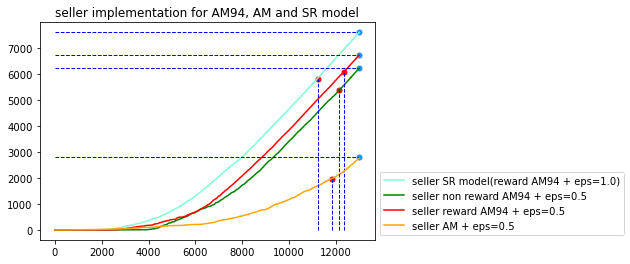

In [319]:
import matplotlib.pyplot as plt
ylreward = np.load('./experiment data/10reward_implementation.npy')/155
lwnoreward = np.load('./experiment data/05noreward_implementation.npy')/155
lwreward = np.load('./experiment data/05reward_implementation.npy')/155
lwam = np.load('./experiment data/implementation_eps=0.5_AM.npy')/155

player = 1

plt.plot(ylreward[0,:,player].cumsum(),c = 'aquamarine')
indexes1 = np.where(~np.isnan(ylreward[0,:,player]))[0][-1] + 1

plt.plot(lwnoreward[0,:,player].cumsum(),c = 'green')
indexes2 = np.where(~np.isnan(lwnoreward[0,:,player]))[0][-1] + 1

plt.plot(lwreward[0,:,player].cumsum(),c= 'red')
indexes3 = np.where(~np.isnan(lwreward[0,:,player]))[0][-1] + 1

plt.plot(lwam[0,:,player].cumsum(),c = 'orange')
indexes4 = np.where(~np.isnan(lwam[0,:,player]))[0][-1] + 1

plt.scatter([indexes1-500],(ylreward[0,:,player].cumsum())[indexes1-500],s=25,c='r')
plt.scatter([13000],(ylreward[0,:,player].cumsum())[indexes1-1]+13001-indexes1,s=25,c='dodgerblue')
plt.plot([-0,13000],[ylreward[0,:,player].cumsum()[indexes1-1]+13001-indexes1,\
                            ylreward[0,:,player].cumsum()[indexes1-1]+13001-indexes1],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1-500,indexes1-500],[0,(ylreward[0,:,player].cumsum())[indexes1-500]],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1-1,13000],[ylreward[0,:,player].cumsum()[indexes1-1],\
                           ylreward[0,:,player].cumsum()[indexes1-1]+13001-indexes1],c = 'aquamarine')


plt.scatter([indexes2-500],(lwnoreward[0,:,player].cumsum())[indexes2-500],s=25,c='r')
plt.scatter([13000],(lwnoreward[0,:,player].cumsum())[indexes2-1]+13001-indexes2,s=25,c='dodgerblue')
plt.plot([-0,13000],[(lwnoreward[0,:,player].cumsum())[indexes2-1]+13001-indexes2,\
                            (lwnoreward[0,:,player].cumsum())[indexes2-1]+13001-indexes2],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes2-500,indexes2-500],[0,(lwnoreward[0,:,player].cumsum())[indexes2-500]],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes2-1,13000],[lwnoreward[0,:,player].cumsum()[indexes2-1],\
                           lwnoreward[0,:,player].cumsum()[indexes2-1]+13001-indexes2],c = 'green')

plt.scatter([indexes3-500],(lwreward[0,:,player].cumsum())[indexes3-500],s=25,c='r')
plt.scatter([13000],(lwreward[0,:,player].cumsum())[indexes3-1]+13001-indexes3,s=25,c='dodgerblue')
plt.plot([-0,13000],[(lwreward[0,:,player].cumsum())[indexes3-1]+13001-indexes3,\
                            (lwreward[0,:,player].cumsum())[indexes3-1]+13001-indexes3],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes3-500,indexes3-500],[0,(lwreward[0,:,player].cumsum())[indexes3-500]],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes3-1,13000],[lwreward[0,:,player].cumsum()[indexes3-1],\
                           lwreward[0,:,player].cumsum()[indexes3-1]+13001-indexes3],c = 'red')

plt.scatter([indexes4-500],(lwam[0,:,player].cumsum())[indexes4-500],s=25,c='r')
plt.scatter([13000],(lwam[0,:,player].cumsum())[indexes4-1]+12901-indexes4,s=25,c='dodgerblue')
plt.plot([-0,13000],[(lwam[0,:,player].cumsum())[indexes4-1]+12901-indexes4,\
                            (lwam[0,:,player].cumsum())[indexes4-1]+12901-indexes4],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes4-500,indexes4-500],[0,(lwam[0,:,player].cumsum())[indexes4-500]],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes4-1,13000],[lwam[0,:,player].cumsum()[indexes4-1],\
                           lwam[0,:,player].cumsum()[indexes4-1]+12851-indexes4],c = 'orange')

plt.legend(labels=['seller SR model(reward AM94 + eps=1.0)',
                   'seller non reward AM94 + eps=0.5',
                   'seller reward AM94 + eps=0.5',
                   'seller AM + eps=0.5'],loc = 3,bbox_to_anchor = (1,0))
plt.title('seller implementation for AM94, AM and SR model')





Text(0.5, 1.0, 'buyer penalty for AM94 and SR* model with different reward and eps=0.5')

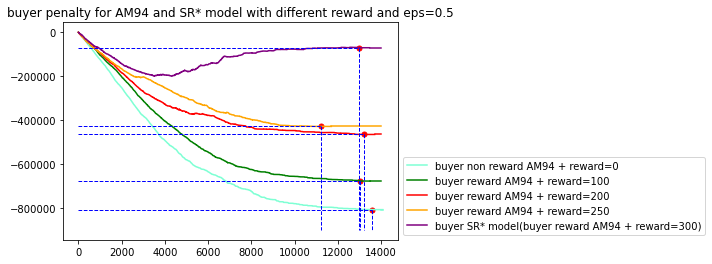

In [320]:
import matplotlib.pyplot as plt
a = np.load('./experiment data/penalty_eps=05_reward=0.npy')
b = np.load('./experiment data/penalty_eps=05_reward=100.npy')
c = np.load('./experiment data/penalty_eps=05_reward=200.npy')
d = np.load('./experiment data/penalty_eps=05_reward=250.npy')
e = np.load('./experiment data/penalty_eps=05_reward=300.npy')

player = 0

plt.plot(a[0,:,player].cumsum(),c = 'aquamarine')

plt.plot(b[0,:,player].cumsum(),c = 'green')

plt.plot(c[0,:,player].cumsum(),c = 'red')

plt.plot(d[0,:,player].cumsum(),c = 'orange')

plt.plot(e[0,:,player].cumsum(),c = 'purple')

indexes1 = np.where(~np.isnan(a[0,:,player]))[0][-1] + 1
plt.scatter([indexes1-500],(a[0,:,player].cumsum())[indexes1-500],s=25,c='r')
plt.plot([-0,indexes1-500],[(a[0,:,player].cumsum())[indexes1-500],\
                            (a[0,:,player].cumsum())[indexes1-500]],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1-500,indexes1-500],[(a[0,:,player].cumsum())[indexes1-500],-900000],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1,14000],[a[0,:,player].cumsum()[indexes1-1],\
                           a[0,:,player].cumsum()[indexes1-1]],c = 'aquamarine')

indexes1 = np.where(~np.isnan(b[0,:,player]))[0][-1] + 1
plt.scatter([indexes1-500],(b[0,:,player].cumsum())[indexes1-500],s=25,c='r')
plt.plot([-0,indexes1-500],[(b[0,:,player].cumsum())[indexes1-500],\
                            (b[0,:,player].cumsum())[indexes1-500]],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1-500,indexes1-500],[(b[0,:,player].cumsum())[indexes1-500],-900000],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1,14000],[b[0,:,player].cumsum()[indexes1-1],\
                           b[0,:,player].cumsum()[indexes1-1]],c = 'green')

indexes1 = np.where(~np.isnan(c[0,:,player]))[0][-1] + 1
plt.scatter([indexes1-500],(c[0,:,player].cumsum())[indexes1-500],s=25,c='r')
plt.plot([-0,indexes1-500],[(c[0,:,player].cumsum())[indexes1-500],\
                            (c[0,:,player].cumsum())[indexes1-500]],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1-500,indexes1-500],[(c[0,:,player].cumsum())[indexes1-500],-900000],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1,14000],[c[0,:,player].cumsum()[indexes1-1],\
                           c[0,:,player].cumsum()[indexes1-1]],c = 'red')

indexes1 = np.where(~np.isnan(d[0,:,player]))[0][-1] + 1
plt.scatter([indexes1-500],(d[0,:,player].cumsum())[indexes1-500],s=25,c='r')
plt.plot([-0,indexes1-500],[(d[0,:,player].cumsum())[indexes1-500],\
                            (d[0,:,player].cumsum())[indexes1-500]],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1-500,indexes1-500],[(d[0,:,player].cumsum())[indexes1-500],-900000],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1,14000],[d[0,:,player].cumsum()[indexes1-1],\
                           d[0,:,player].cumsum()[indexes1-1]],c = 'orange')

indexes1 = np.where(~np.isnan(e[0,:,player]))[0][-1] + 1
plt.scatter([indexes1-500],(e[0,:,player].cumsum())[indexes1-500],s=25,c='r')
plt.plot([-0,indexes1-500],[(e[0,:,player].cumsum())[indexes1-500],\
                            (e[0,:,player].cumsum())[indexes1-500]],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1-500,indexes1-500],[(e[0,:,player].cumsum())[indexes1-500],-900000],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1,14000],[e[0,:,player].cumsum()[indexes1-1],\
                           e[0,:,player].cumsum()[indexes1-1]],c = 'purple')

plt.legend(labels=[
                   'buyer non reward AM94 + reward=0',

                   'buyer reward AM94 + reward=100',

                   'buyer reward AM94 + reward=200',

                   'buyer reward AM94 + reward=250',

                   'buyer SR* model(buyer reward AM94 + reward=300)',],loc = 3,bbox_to_anchor = (1,0))
plt.title('buyer penalty for AM94 and SR* model with different reward and eps=0.5')



Text(0.5, 1.0, 'seller penalty for AM94 and SR* model with different reward and eps=0.5')

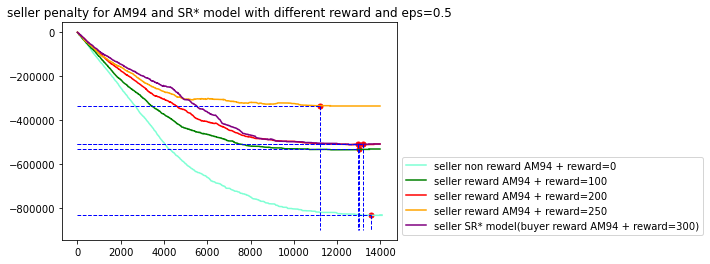

In [321]:
import matplotlib.pyplot as plt
a = np.load('./experiment data/penalty_eps=05_reward=0.npy')
b = np.load('./experiment data/penalty_eps=05_reward=100.npy')
c = np.load('./experiment data/penalty_eps=05_reward=200.npy')
d = np.load('./experiment data/penalty_eps=05_reward=250.npy')
e = np.load('./experiment data/penalty_eps=05_reward=300.npy')

player = 1

plt.plot(a[0,:,player].cumsum(),c = 'aquamarine')

plt.plot(b[0,:,player].cumsum(),c = 'green')

plt.plot(c[0,:,player].cumsum(),c = 'red')

plt.plot(d[0,:,player].cumsum(),c = 'orange')

plt.plot(e[0,:,player].cumsum(),c = 'purple')

indexes1 = np.where(~np.isnan(a[0,:,player]))[0][-1] + 1
plt.scatter([indexes1-500],(a[0,:,player].cumsum())[indexes1-500],s=25,c='r')
plt.plot([-0,indexes1-500],[(a[0,:,player].cumsum())[indexes1-500],\
                            (a[0,:,player].cumsum())[indexes1-500]],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1-500,indexes1-500],[(a[0,:,player].cumsum())[indexes1-500],-900000],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1,14000],[a[0,:,player].cumsum()[indexes1-1],\
                           a[0,:,player].cumsum()[indexes1-1]],c = 'aquamarine')

indexes1 = np.where(~np.isnan(b[0,:,player]))[0][-1] + 1
plt.scatter([indexes1-500],(b[0,:,player].cumsum())[indexes1-500],s=25,c='r')
plt.plot([-0,indexes1-500],[(b[0,:,player].cumsum())[indexes1-500],\
                            (b[0,:,player].cumsum())[indexes1-500]],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1-500,indexes1-500],[(b[0,:,player].cumsum())[indexes1-500],-900000],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1,14000],[b[0,:,player].cumsum()[indexes1-1],\
                           b[0,:,player].cumsum()[indexes1-1]],c = 'green')

indexes1 = np.where(~np.isnan(c[0,:,player]))[0][-1] + 1
plt.scatter([indexes1-500],(c[0,:,player].cumsum())[indexes1-500],s=25,c='r')
plt.plot([-0,indexes1-500],[(c[0,:,player].cumsum())[indexes1-500],\
                            (c[0,:,player].cumsum())[indexes1-500]],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1-500,indexes1-500],[(c[0,:,player].cumsum())[indexes1-500],-900000],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1,14000],[c[0,:,player].cumsum()[indexes1-1],\
                           c[0,:,player].cumsum()[indexes1-1]],c = 'red')

indexes1 = np.where(~np.isnan(d[0,:,player]))[0][-1] + 1
plt.scatter([indexes1-500],(d[0,:,player].cumsum())[indexes1-500],s=25,c='r')
plt.plot([-0,indexes1-500],[(d[0,:,player].cumsum())[indexes1-500],\
                            (d[0,:,player].cumsum())[indexes1-500]],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1-500,indexes1-500],[(d[0,:,player].cumsum())[indexes1-500],-900000],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1,14000],[d[0,:,player].cumsum()[indexes1-1],\
                           d[0,:,player].cumsum()[indexes1-1]],c = 'orange')

indexes1 = np.where(~np.isnan(e[0,:,player]))[0][-1] + 1
plt.scatter([indexes1-500],(e[0,:,player].cumsum())[indexes1-500],s=25,c='r')
plt.plot([-0,indexes1-500],[(e[0,:,player].cumsum())[indexes1-500],\
                            (e[0,:,player].cumsum())[indexes1-500]],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1-500,indexes1-500],[(e[0,:,player].cumsum())[indexes1-500],-900000],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1,14000],[e[0,:,player].cumsum()[indexes1-1],\
                           e[0,:,player].cumsum()[indexes1-1]],c = 'purple')

plt.legend(labels=[
                   'seller non reward AM94 + reward=0',

                   'seller reward AM94 + reward=100',

                   'seller reward AM94 + reward=200',

                   'seller reward AM94 + reward=250',

                   'seller SR* model(buyer reward AM94 + reward=300)',],loc = 3,bbox_to_anchor = (1,0))
plt.title('seller penalty for AM94 and SR* model with different reward and eps=0.5')




Text(0.5, 1.0, 'buyer implementation for AM94 and SR* model with different reward and eps=0.5')

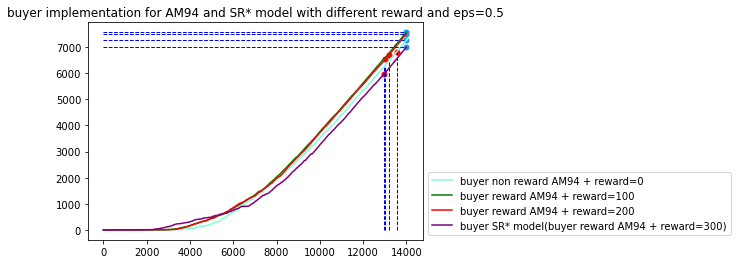

In [326]:
import matplotlib.pyplot as plt
a = np.load('./experiment data/implementation_eps=05_reward=0.npy')/155
b = np.load('./experiment data/implementation_eps=05_reward=100.npy')/155
c = np.load('./experiment data/implementation_eps=05_reward=200.npy')/155
d = np.load('./experiment data/implementation_eps=05_reward=250.npy')/155
e = np.load('./experiment data/implementation_eps=05_reward=300.npy')/155

player = 0

plt.plot(a[0,:,player].cumsum(),c = 'aquamarine')

plt.plot(b[0,:,player].cumsum(),c = 'green')

plt.plot(c[0,:,player].cumsum(),c = 'red')


plt.plot(e[0,:,player].cumsum(),c = 'purple')

indexes1 = np.where(~np.isnan(a[0,:,player]))[0][-1] + 1
plt.scatter([indexes1-500],(a[0,:,player].cumsum())[indexes1-500],s=25,c='r')
plt.scatter([14000],(a[0,:,player].cumsum())[indexes1-1]+14001-indexes1,s=25,c='dodgerblue')
plt.plot([-0,14000],[a[0,:,player].cumsum()[indexes1-1]+14001-indexes1,\
                            a[0,:,player].cumsum()[indexes1-1]+14001-indexes1],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1-500,indexes1-500],[0,(a[0,:,player].cumsum())[indexes1-500]],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1-1,14000],[a[0,:,player].cumsum()[indexes1-1],\
                           a[0,:,player].cumsum()[indexes1-1]+14001-indexes1],c = 'aquamarine')


indexes1 = np.where(~np.isnan(b[0,:,player]))[0][-1] + 1
plt.scatter([indexes1-500],(b[0,:,player].cumsum())[indexes1-500],s=25,c='r')
plt.scatter([14000],(b[0,:,player].cumsum())[indexes1-1]+14001-indexes1,s=25,c='dodgerblue')
plt.plot([-0,14000],[b[0,:,player].cumsum()[indexes1-1]+14001-indexes1,\
                            b[0,:,player].cumsum()[indexes1-1]+14001-indexes1],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1-500,indexes1-500],[0,(a[0,:,player].cumsum())[indexes1-500]],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1-1,14000],[b[0,:,player].cumsum()[indexes1-1],\
                           b[0,:,player].cumsum()[indexes1-1]+14001-indexes1],c = 'green')

indexes1 = np.where(~np.isnan(c[0,:,player]))[0][-1] + 1
plt.scatter([indexes1-500],(c[0,:,player].cumsum())[indexes1-500],s=25,c='r')
plt.scatter([14000],(c[0,:,player].cumsum())[indexes1-1]+14001-indexes1,s=25,c='dodgerblue')
plt.plot([-0,14000],[c[0,:,player].cumsum()[indexes1-1]+14001-indexes1,\
                            c[0,:,player].cumsum()[indexes1-1]+14001-indexes1],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1-500,indexes1-500],[0,(a[0,:,player].cumsum())[indexes1-500]],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1-1,14000],[c[0,:,player].cumsum()[indexes1-1],\
                           c[0,:,player].cumsum()[indexes1-1]+14001-indexes1],c = 'red')

indexes1 = np.where(~np.isnan(e[0,:,player]))[0][-1] + 1
plt.scatter([indexes1-500],(e[0,:,player].cumsum())[indexes1-500],s=25,c='r')
plt.scatter([14000],(e[0,:,player].cumsum())[indexes1-1]+14001-indexes1,s=25,c='dodgerblue')
plt.plot([-0,14000],[e[0,:,player].cumsum()[indexes1-1]+14001-indexes1,\
                            e[0,:,player].cumsum()[indexes1-1]+14001-indexes1],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1-500,indexes1-500],[0,(a[0,:,player].cumsum())[indexes1-500]],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1-1,14000],[e[0,:,player].cumsum()[indexes1-1],\
                           e[0,:,player].cumsum()[indexes1-1]+14001-indexes1],c = 'purple')


plt.legend(labels=[
                   'buyer non reward AM94 + reward=0',

                   'buyer reward AM94 + reward=100',

                   'buyer reward AM94 + reward=200',

                   'buyer SR* model(buyer reward AM94 + reward=300)',],loc = 3,bbox_to_anchor = (1,0))
plt.title('buyer implementation for AM94 and SR* model with different reward and eps=0.5')




Text(0.5, 1.0, 'seller implementation for AM94 and SR* model with different reward and eps=0.5')

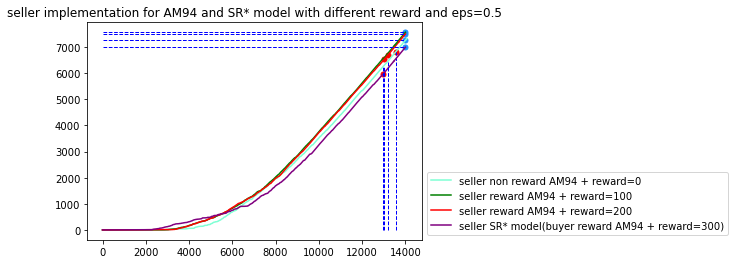

In [327]:
import matplotlib.pyplot as plt
a = np.load('./experiment data/implementation_eps=05_reward=0.npy')/155
b = np.load('./experiment data/implementation_eps=05_reward=100.npy')/155
c = np.load('./experiment data/implementation_eps=05_reward=200.npy')/155
d = np.load('./experiment data/implementation_eps=05_reward=250.npy')/155
e = np.load('./experiment data/implementation_eps=05_reward=300.npy')/155

player = 1

plt.plot(a[0,:,player].cumsum(),c = 'aquamarine')

plt.plot(b[0,:,player].cumsum(),c = 'green')

plt.plot(c[0,:,player].cumsum(),c = 'red')


plt.plot(e[0,:,player].cumsum(),c = 'purple')

indexes1 = np.where(~np.isnan(a[0,:,player]))[0][-1] + 1
plt.scatter([indexes1-500],(a[0,:,player].cumsum())[indexes1-500],s=25,c='r')
plt.scatter([14000],(a[0,:,player].cumsum())[indexes1-1]+14001-indexes1,s=25,c='dodgerblue')
plt.plot([-0,14000],[a[0,:,player].cumsum()[indexes1-1]+14001-indexes1,\
                            a[0,:,player].cumsum()[indexes1-1]+14001-indexes1],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1-500,indexes1-500],[0,(a[0,:,player].cumsum())[indexes1-500]],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1-1,14000],[a[0,:,player].cumsum()[indexes1-1],\
                           a[0,:,player].cumsum()[indexes1-1]+14001-indexes1],c = 'aquamarine')


indexes1 = np.where(~np.isnan(b[0,:,player]))[0][-1] + 1
plt.scatter([indexes1-500],(b[0,:,player].cumsum())[indexes1-500],s=25,c='r')
plt.scatter([14000],(b[0,:,player].cumsum())[indexes1-1]+14001-indexes1,s=25,c='dodgerblue')
plt.plot([-0,14000],[b[0,:,player].cumsum()[indexes1-1]+14001-indexes1,\
                            b[0,:,player].cumsum()[indexes1-1]+14001-indexes1],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1-500,indexes1-500],[0,(a[0,:,player].cumsum())[indexes1-500]],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1-1,14000],[b[0,:,player].cumsum()[indexes1-1],\
                           b[0,:,player].cumsum()[indexes1-1]+14001-indexes1],c = 'green')

indexes1 = np.where(~np.isnan(c[0,:,player]))[0][-1] + 1
plt.scatter([indexes1-500],(c[0,:,player].cumsum())[indexes1-500],s=25,c='r')
plt.scatter([14000],(c[0,:,player].cumsum())[indexes1-1]+14001-indexes1,s=25,c='dodgerblue')
plt.plot([-0,14000],[c[0,:,player].cumsum()[indexes1-1]+14001-indexes1,\
                            c[0,:,player].cumsum()[indexes1-1]+14001-indexes1],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1-500,indexes1-500],[0,(a[0,:,player].cumsum())[indexes1-500]],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1-1,14000],[c[0,:,player].cumsum()[indexes1-1],\
                           c[0,:,player].cumsum()[indexes1-1]+14001-indexes1],c = 'red')

indexes1 = np.where(~np.isnan(e[0,:,player]))[0][-1] + 1
plt.scatter([indexes1-500],(e[0,:,player].cumsum())[indexes1-500],s=25,c='r')
plt.scatter([14000],(e[0,:,player].cumsum())[indexes1-1]+14001-indexes1,s=25,c='dodgerblue')
plt.plot([-0,14000],[e[0,:,player].cumsum()[indexes1-1]+14001-indexes1,\
                            e[0,:,player].cumsum()[indexes1-1]+14001-indexes1],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1-500,indexes1-500],[0,(a[0,:,player].cumsum())[indexes1-500]],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1-1,14000],[e[0,:,player].cumsum()[indexes1-1],\
                           e[0,:,player].cumsum()[indexes1-1]+14001-indexes1],c = 'purple')


plt.legend(labels=[
                   'seller non reward AM94 + reward=0',

                   'seller reward AM94 + reward=100',

                   'seller reward AM94 + reward=200',

                   'seller SR* model(buyer reward AM94 + reward=300)',],loc = 3,bbox_to_anchor = (1,0))
plt.title('seller implementation for AM94 and SR* model with different reward and eps=0.5')





Text(0.5, 1.0, 'buyer implementation for AM94 and SR model with different eps and 300reward')

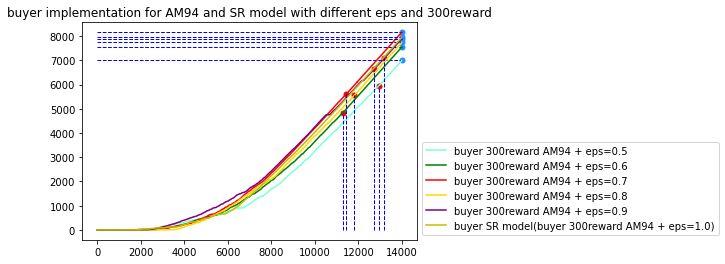

In [334]:
import matplotlib.pyplot as plt
a = np.load('./experiment data/implementation_eps=05_reward=300.npy')/155
b = np.load('./experiment data/implementation_eps=06_reward=300.npy')/155
c = np.load('./experiment data/implementation_eps=07_reward=300.npy')/155
d = np.load('./experiment data/implementation_eps=08_reward=300.npy')/155
e = np.load('./experiment data/implementation_eps=09_reward=300.npy')/155
f = np.load('./experiment data/implementation_eps=10_reward=300.npy')/155

player = 0

plt.plot(a[0,:,player].cumsum(),c = 'aquamarine')

plt.plot(b[0,:,player].cumsum(),c = 'green')

plt.plot(c[0,:,player].cumsum(),c = 'red')

plt.plot(d[0,:,player].cumsum(),c = 'gold')

plt.plot(e[0,:,player].cumsum(),c = 'purple')

plt.plot(f[0,:,player].cumsum(),c = 'y')

indexes1 = np.where(~np.isnan(a[0,:,player]))[0][-1] + 1
plt.scatter([indexes1-500],(a[0,:,player].cumsum())[indexes1-500],s=25,c='r')
plt.scatter([14000],(a[0,:,player].cumsum())[indexes1-1]+14001-indexes1,s=25,c='dodgerblue')
plt.plot([-0,14000],[a[0,:,player].cumsum()[indexes1-1]+14001-indexes1,\
                            a[0,:,player].cumsum()[indexes1-1]+14001-indexes1],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1-500,indexes1-500],[0,(a[0,:,player].cumsum())[indexes1-500]],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1-1,14000],[a[0,:,player].cumsum()[indexes1-1],\
                           a[0,:,player].cumsum()[indexes1-1]+14001-indexes1],c = 'aquamarine')

indexes1 = np.where(~np.isnan(b[0,:,player]))[0][-1] + 1
plt.scatter([indexes1-500],(b[0,:,player].cumsum())[indexes1-500],s=25,c='r')
plt.scatter([14000],(b[0,:,player].cumsum())[indexes1-1]+14001-indexes1,s=25,c='dodgerblue')
plt.plot([-0,14000],[b[0,:,player].cumsum()[indexes1-1]+14001-indexes1,\
                            b[0,:,player].cumsum()[indexes1-1]+14001-indexes1],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1-500,indexes1-500],[0,(b[0,:,player].cumsum())[indexes1-500]],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1-1,14000],[b[0,:,player].cumsum()[indexes1-1],\
                           b[0,:,player].cumsum()[indexes1-1]+14001-indexes1],c = 'green')

indexes1 = np.where(~np.isnan(c[0,:,player]))[0][-1] + 1
plt.scatter([indexes1-500],(c[0,:,player].cumsum())[indexes1-500],s=25,c='r')
plt.scatter([14000],(c[0,:,player].cumsum())[indexes1-1]+14001-indexes1,s=25,c='dodgerblue')
plt.plot([-0,14000],[c[0,:,player].cumsum()[indexes1-1]+14001-indexes1,\
                            c[0,:,player].cumsum()[indexes1-1]+14001-indexes1],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1-500,indexes1-500],[0,(c[0,:,player].cumsum())[indexes1-500]],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1-1,14000],[c[0,:,player].cumsum()[indexes1-1],\
                           c[0,:,player].cumsum()[indexes1-1]+14001-indexes1],c = 'red')

indexes1 = np.where(~np.isnan(d[0,:,player]))[0][-1] + 1
plt.scatter([indexes1-500],(d[0,:,player].cumsum())[indexes1-500],s=25,c='r')
plt.scatter([14000],(d[0,:,player].cumsum())[indexes1-1]+14001-indexes1,s=25,c='dodgerblue')
plt.plot([-0,14000],[d[0,:,player].cumsum()[indexes1-1]+14001-indexes1,\
                            d[0,:,player].cumsum()[indexes1-1]+14001-indexes1],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1-500,indexes1-500],[0,(d[0,:,player].cumsum())[indexes1-500]],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1-1,14000],[d[0,:,player].cumsum()[indexes1-1],\
                           d[0,:,player].cumsum()[indexes1-1]+14001-indexes1],c = 'gold')

indexes1 = np.where(~np.isnan(e[0,:,player]))[0][-1] + 1
plt.scatter([indexes1-500],(e[0,:,player].cumsum())[indexes1-500],s=25,c='r')
plt.scatter([14000],(e[0,:,player].cumsum())[indexes1-1]+14001-indexes1,s=25,c='dodgerblue')
plt.plot([-0,14000],[e[0,:,player].cumsum()[indexes1-1]+14001-indexes1,\
                            e[0,:,player].cumsum()[indexes1-1]+14001-indexes1],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1-500,indexes1-500],[0,(e[0,:,player].cumsum())[indexes1-500]],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1-1,14000],[e[0,:,player].cumsum()[indexes1-1],\
                           e[0,:,player].cumsum()[indexes1-1]+14001-indexes1],c = 'purple')

indexes1 = np.where(~np.isnan(f[0,:,player]))[0][-1] + 1
plt.scatter([indexes1-500],(f[0,:,player].cumsum())[indexes1-500],s=25,c='r')
plt.scatter([14000],(f[0,:,player].cumsum())[indexes1-1]+14001-indexes1,s=25,c='dodgerblue')
plt.plot([-0,14000],[f[0,:,player].cumsum()[indexes1-1]+14001-indexes1,\
                            f[0,:,player].cumsum()[indexes1-1]+14001-indexes1],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1-500,indexes1-500],[0,(f[0,:,player].cumsum())[indexes1-500]],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1-1,14000],[f[0,:,player].cumsum()[indexes1-1],\
                           f[0,:,player].cumsum()[indexes1-1]+14001-indexes1],c = 'y')

plt.legend(labels=[
                   'buyer 300reward AM94 + eps=0.5',

                   'buyer 300reward AM94 + eps=0.6',

                   'buyer 300reward AM94 + eps=0.7',

                   'buyer 300reward AM94 + eps=0.8',
    
                   'buyer 300reward AM94 + eps=0.9',
    
                   'buyer SR model(buyer 300reward AM94 + eps=1.0)',],loc = 3,bbox_to_anchor = (1,0))
plt.title('buyer implementation for AM94 and SR model with different eps and 300reward')





Text(0.5, 1.0, 'seller implementation for AM94 and SR model with different eps and 300reward')

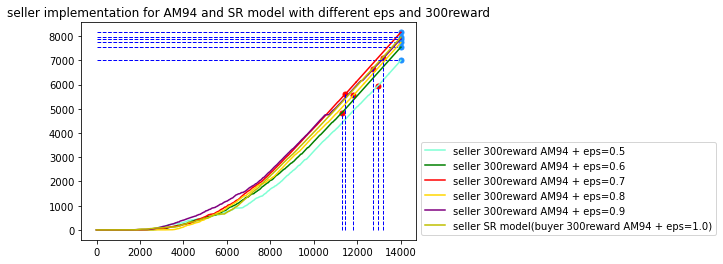

In [335]:
import matplotlib.pyplot as plt
a = np.load('./experiment data/implementation_eps=05_reward=300.npy')/155
b = np.load('./experiment data/implementation_eps=06_reward=300.npy')/155
c = np.load('./experiment data/implementation_eps=07_reward=300.npy')/155
d = np.load('./experiment data/implementation_eps=08_reward=300.npy')/155
e = np.load('./experiment data/implementation_eps=09_reward=300.npy')/155
f = np.load('./experiment data/implementation_eps=10_reward=300.npy')/155

player = 1

plt.plot(a[0,:,player].cumsum(),c = 'aquamarine')

plt.plot(b[0,:,player].cumsum(),c = 'green')

plt.plot(c[0,:,player].cumsum(),c = 'red')

plt.plot(d[0,:,player].cumsum(),c = 'gold')

plt.plot(e[0,:,player].cumsum(),c = 'purple')

plt.plot(f[0,:,player].cumsum(),c = 'y')

indexes1 = np.where(~np.isnan(a[0,:,player]))[0][-1] + 1
plt.scatter([indexes1-500],(a[0,:,player].cumsum())[indexes1-500],s=25,c='r')
plt.scatter([14000],(a[0,:,player].cumsum())[indexes1-1]+14001-indexes1,s=25,c='dodgerblue')
plt.plot([-0,14000],[a[0,:,player].cumsum()[indexes1-1]+14001-indexes1,\
                            a[0,:,player].cumsum()[indexes1-1]+14001-indexes1],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1-500,indexes1-500],[0,(a[0,:,player].cumsum())[indexes1-500]],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1-1,14000],[a[0,:,player].cumsum()[indexes1-1],\
                           a[0,:,player].cumsum()[indexes1-1]+14001-indexes1],c = 'aquamarine')

indexes1 = np.where(~np.isnan(b[0,:,player]))[0][-1] + 1
plt.scatter([indexes1-500],(b[0,:,player].cumsum())[indexes1-500],s=25,c='r')
plt.scatter([14000],(b[0,:,player].cumsum())[indexes1-1]+14001-indexes1,s=25,c='dodgerblue')
plt.plot([-0,14000],[b[0,:,player].cumsum()[indexes1-1]+14001-indexes1,\
                            b[0,:,player].cumsum()[indexes1-1]+14001-indexes1],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1-500,indexes1-500],[0,(b[0,:,player].cumsum())[indexes1-500]],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1-1,14000],[b[0,:,player].cumsum()[indexes1-1],\
                           b[0,:,player].cumsum()[indexes1-1]+14001-indexes1],c = 'green')

indexes1 = np.where(~np.isnan(c[0,:,player]))[0][-1] + 1
plt.scatter([indexes1-500],(c[0,:,player].cumsum())[indexes1-500],s=25,c='r')
plt.scatter([14000],(c[0,:,player].cumsum())[indexes1-1]+14001-indexes1,s=25,c='dodgerblue')
plt.plot([-0,14000],[c[0,:,player].cumsum()[indexes1-1]+14001-indexes1,\
                            c[0,:,player].cumsum()[indexes1-1]+14001-indexes1],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1-500,indexes1-500],[0,(c[0,:,player].cumsum())[indexes1-500]],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1-1,14000],[c[0,:,player].cumsum()[indexes1-1],\
                           c[0,:,player].cumsum()[indexes1-1]+14001-indexes1],c = 'red')

indexes1 = np.where(~np.isnan(d[0,:,player]))[0][-1] + 1
plt.scatter([indexes1-500],(d[0,:,player].cumsum())[indexes1-500],s=25,c='r')
plt.scatter([14000],(d[0,:,player].cumsum())[indexes1-1]+14001-indexes1,s=25,c='dodgerblue')
plt.plot([-0,14000],[d[0,:,player].cumsum()[indexes1-1]+14001-indexes1,\
                            d[0,:,player].cumsum()[indexes1-1]+14001-indexes1],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1-500,indexes1-500],[0,(d[0,:,player].cumsum())[indexes1-500]],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1-1,14000],[d[0,:,player].cumsum()[indexes1-1],\
                           d[0,:,player].cumsum()[indexes1-1]+14001-indexes1],c = 'gold')

indexes1 = np.where(~np.isnan(e[0,:,player]))[0][-1] + 1
plt.scatter([indexes1-500],(e[0,:,player].cumsum())[indexes1-500],s=25,c='r')
plt.scatter([14000],(e[0,:,player].cumsum())[indexes1-1]+14001-indexes1,s=25,c='dodgerblue')
plt.plot([-0,14000],[e[0,:,player].cumsum()[indexes1-1]+14001-indexes1,\
                            e[0,:,player].cumsum()[indexes1-1]+14001-indexes1],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1-500,indexes1-500],[0,(e[0,:,player].cumsum())[indexes1-500]],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1-1,14000],[e[0,:,player].cumsum()[indexes1-1],\
                           e[0,:,player].cumsum()[indexes1-1]+14001-indexes1],c = 'purple')

indexes1 = np.where(~np.isnan(f[0,:,player]))[0][-1] + 1
plt.scatter([indexes1-500],(f[0,:,player].cumsum())[indexes1-500],s=25,c='r')
plt.scatter([14000],(f[0,:,player].cumsum())[indexes1-1]+14001-indexes1,s=25,c='dodgerblue')
plt.plot([-0,14000],[f[0,:,player].cumsum()[indexes1-1]+14001-indexes1,\
                            f[0,:,player].cumsum()[indexes1-1]+14001-indexes1],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1-500,indexes1-500],[0,(f[0,:,player].cumsum())[indexes1-500]],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1-1,14000],[f[0,:,player].cumsum()[indexes1-1],\
                           f[0,:,player].cumsum()[indexes1-1]+14001-indexes1],c = 'y')

plt.legend(labels=[
                   'seller 300reward AM94 + eps=0.5',

                   'seller 300reward AM94 + eps=0.6',

                   'seller 300reward AM94 + eps=0.7',

                   'seller 300reward AM94 + eps=0.8',
    
                   'seller 300reward AM94 + eps=0.9',
    
                   'seller SR model(buyer 300reward AM94 + eps=1.0)',],loc = 3,bbox_to_anchor = (1,0))
plt.title('seller implementation for AM94 and SR model with different eps and 300reward')






Text(0.5, 1.0, 'buyer penalty for AM94 and SR model with different eps and 300reward')

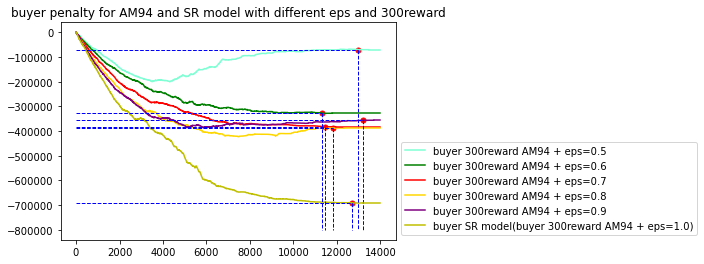

In [337]:
import matplotlib.pyplot as plt
a = np.load('./experiment data/penalty_eps=05_reward=300.npy')
b = np.load('./experiment data/penalty_eps=06_reward=300.npy')
c = np.load('./experiment data/penalty_eps=07_reward=300.npy')
d = np.load('./experiment data/penalty_eps=08_reward=300.npy')
e = np.load('./experiment data/penalty_eps=09_reward=300.npy')
f = np.load('./experiment data/penalty_eps=10_reward=300.npy')

player = 0

plt.plot(a[0,:,player].cumsum(),c = 'aquamarine')

plt.plot(b[0,:,player].cumsum(),c = 'green')

plt.plot(c[0,:,player].cumsum(),c = 'red')

plt.plot(d[0,:,player].cumsum(),c = 'gold')

plt.plot(e[0,:,player].cumsum(),c = 'purple')

plt.plot(f[0,:,player].cumsum(),c = 'y')

indexes1 = np.where(~np.isnan(a[0,:,player]))[0][-1] + 1
plt.scatter([indexes1-500],(a[0,:,player].cumsum())[indexes1-500],s=25,c='r')
plt.plot([-0,indexes1-500],[(a[0,:,player].cumsum())[indexes1-500],\
                            (a[0,:,player].cumsum())[indexes1-500]],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1-500,indexes1-500],[(a[0,:,player].cumsum())[indexes1-500],-800000],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1,14000],[a[0,:,player].cumsum()[indexes1-1],\
                           a[0,:,player].cumsum()[indexes1-1]],c = 'aquamarine')

indexes1 = np.where(~np.isnan(b[0,:,player]))[0][-1] + 1
plt.scatter([indexes1-500],(b[0,:,player].cumsum())[indexes1-500],s=25,c='r')
plt.plot([-0,indexes1-500],[(b[0,:,player].cumsum())[indexes1-500],\
                            (b[0,:,player].cumsum())[indexes1-500]],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1-500,indexes1-500],[(b[0,:,player].cumsum())[indexes1-500],-800000],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1,14000],[b[0,:,player].cumsum()[indexes1-1],\
                           b[0,:,player].cumsum()[indexes1-1]],c = 'green')

indexes1 = np.where(~np.isnan(c[0,:,player]))[0][-1] + 1
plt.scatter([indexes1-500],(c[0,:,player].cumsum())[indexes1-500],s=25,c='r')
plt.plot([-0,indexes1-500],[(c[0,:,player].cumsum())[indexes1-500],\
                            (c[0,:,player].cumsum())[indexes1-500]],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1-500,indexes1-500],[(c[0,:,player].cumsum())[indexes1-500],-800000],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1,14000],[c[0,:,player].cumsum()[indexes1-1],\
                           c[0,:,player].cumsum()[indexes1-1]],c = 'red')

indexes1 = np.where(~np.isnan(d[0,:,player]))[0][-1] + 1
plt.scatter([indexes1-500],(d[0,:,player].cumsum())[indexes1-500],s=25,c='r')
plt.plot([-0,indexes1-500],[(d[0,:,player].cumsum())[indexes1-500],\
                            (d[0,:,player].cumsum())[indexes1-500]],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1-500,indexes1-500],[(d[0,:,player].cumsum())[indexes1-500],-800000],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1,14000],[d[0,:,player].cumsum()[indexes1-1],\
                           d[0,:,player].cumsum()[indexes1-1]],c = 'gold')

indexes1 = np.where(~np.isnan(e[0,:,player]))[0][-1] + 1
plt.scatter([indexes1-500],(e[0,:,player].cumsum())[indexes1-500],s=25,c='r')
plt.plot([-0,indexes1-500],[(e[0,:,player].cumsum())[indexes1-500],\
                            (e[0,:,player].cumsum())[indexes1-500]],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1-500,indexes1-500],[(e[0,:,player].cumsum())[indexes1-500],-800000],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1,14000],[e[0,:,player].cumsum()[indexes1-1],\
                           e[0,:,player].cumsum()[indexes1-1]],c = 'purple')

indexes1 = np.where(~np.isnan(f[0,:,player]))[0][-1] + 1
plt.scatter([indexes1-500],(f[0,:,player].cumsum())[indexes1-500],s=25,c='r')
plt.plot([-0,indexes1-500],[(f[0,:,player].cumsum())[indexes1-500],\
                            (f[0,:,player].cumsum())[indexes1-500]],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1-500,indexes1-500],[(f[0,:,player].cumsum())[indexes1-500],-800000],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1,14000],[f[0,:,player].cumsum()[indexes1-1],\
                           f[0,:,player].cumsum()[indexes1-1]],c = 'y')

plt.legend(labels=[
                   'buyer 300reward AM94 + eps=0.5',

                   'buyer 300reward AM94 + eps=0.6',

                   'buyer 300reward AM94 + eps=0.7',

                   'buyer 300reward AM94 + eps=0.8',
    
                   'buyer 300reward AM94 + eps=0.9',
    
                   'buyer SR model(buyer 300reward AM94 + eps=1.0)',],loc = 3,bbox_to_anchor = (1,0))
plt.title('buyer penalty for AM94 and SR model with different eps and 300reward')






Text(0.5, 1.0, 'seller penalty for AM94 and SR model with different eps and 300reward')

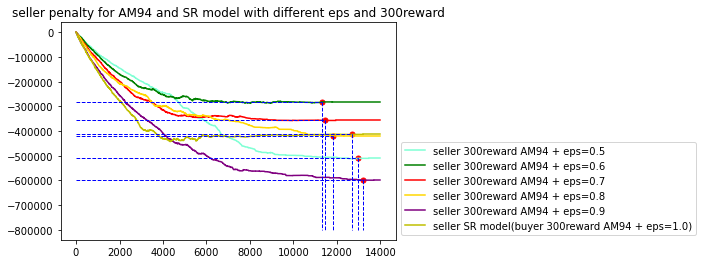

In [338]:
import matplotlib.pyplot as plt
a = np.load('./experiment data/penalty_eps=05_reward=300.npy')
b = np.load('./experiment data/penalty_eps=06_reward=300.npy')
c = np.load('./experiment data/penalty_eps=07_reward=300.npy')
d = np.load('./experiment data/penalty_eps=08_reward=300.npy')
e = np.load('./experiment data/penalty_eps=09_reward=300.npy')
f = np.load('./experiment data/penalty_eps=10_reward=300.npy')

player = 1

plt.plot(a[0,:,player].cumsum(),c = 'aquamarine')

plt.plot(b[0,:,player].cumsum(),c = 'green')

plt.plot(c[0,:,player].cumsum(),c = 'red')

plt.plot(d[0,:,player].cumsum(),c = 'gold')

plt.plot(e[0,:,player].cumsum(),c = 'purple')

plt.plot(f[0,:,player].cumsum(),c = 'y')

indexes1 = np.where(~np.isnan(a[0,:,player]))[0][-1] + 1
plt.scatter([indexes1-500],(a[0,:,player].cumsum())[indexes1-500],s=25,c='r')
plt.plot([-0,indexes1-500],[(a[0,:,player].cumsum())[indexes1-500],\
                            (a[0,:,player].cumsum())[indexes1-500]],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1-500,indexes1-500],[(a[0,:,player].cumsum())[indexes1-500],-800000],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1,14000],[a[0,:,player].cumsum()[indexes1-1],\
                           a[0,:,player].cumsum()[indexes1-1]],c = 'aquamarine')

indexes1 = np.where(~np.isnan(b[0,:,player]))[0][-1] + 1
plt.scatter([indexes1-500],(b[0,:,player].cumsum())[indexes1-500],s=25,c='r')
plt.plot([-0,indexes1-500],[(b[0,:,player].cumsum())[indexes1-500],\
                            (b[0,:,player].cumsum())[indexes1-500]],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1-500,indexes1-500],[(b[0,:,player].cumsum())[indexes1-500],-800000],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1,14000],[b[0,:,player].cumsum()[indexes1-1],\
                           b[0,:,player].cumsum()[indexes1-1]],c = 'green')

indexes1 = np.where(~np.isnan(c[0,:,player]))[0][-1] + 1
plt.scatter([indexes1-500],(c[0,:,player].cumsum())[indexes1-500],s=25,c='r')
plt.plot([-0,indexes1-500],[(c[0,:,player].cumsum())[indexes1-500],\
                            (c[0,:,player].cumsum())[indexes1-500]],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1-500,indexes1-500],[(c[0,:,player].cumsum())[indexes1-500],-800000],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1,14000],[c[0,:,player].cumsum()[indexes1-1],\
                           c[0,:,player].cumsum()[indexes1-1]],c = 'red')

indexes1 = np.where(~np.isnan(d[0,:,player]))[0][-1] + 1
plt.scatter([indexes1-500],(d[0,:,player].cumsum())[indexes1-500],s=25,c='r')
plt.plot([-0,indexes1-500],[(d[0,:,player].cumsum())[indexes1-500],\
                            (d[0,:,player].cumsum())[indexes1-500]],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1-500,indexes1-500],[(d[0,:,player].cumsum())[indexes1-500],-800000],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1,14000],[d[0,:,player].cumsum()[indexes1-1],\
                           d[0,:,player].cumsum()[indexes1-1]],c = 'gold')

indexes1 = np.where(~np.isnan(e[0,:,player]))[0][-1] + 1
plt.scatter([indexes1-500],(e[0,:,player].cumsum())[indexes1-500],s=25,c='r')
plt.plot([-0,indexes1-500],[(e[0,:,player].cumsum())[indexes1-500],\
                            (e[0,:,player].cumsum())[indexes1-500]],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1-500,indexes1-500],[(e[0,:,player].cumsum())[indexes1-500],-800000],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1,14000],[e[0,:,player].cumsum()[indexes1-1],\
                           e[0,:,player].cumsum()[indexes1-1]],c = 'purple')

indexes1 = np.where(~np.isnan(f[0,:,player]))[0][-1] + 1
plt.scatter([indexes1-500],(f[0,:,player].cumsum())[indexes1-500],s=25,c='r')
plt.plot([-0,indexes1-500],[(f[0,:,player].cumsum())[indexes1-500],\
                            (f[0,:,player].cumsum())[indexes1-500]],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1-500,indexes1-500],[(f[0,:,player].cumsum())[indexes1-500],-800000],\
                             c = 'b',linestyle = '--',linewidth = 1)
plt.plot([indexes1,14000],[f[0,:,player].cumsum()[indexes1-1],\
                           f[0,:,player].cumsum()[indexes1-1]],c = 'y')

plt.legend(labels=[
                   'seller 300reward AM94 + eps=0.5',

                   'seller 300reward AM94 + eps=0.6',

                   'seller 300reward AM94 + eps=0.7',

                   'seller 300reward AM94 + eps=0.8',
    
                   'seller 300reward AM94 + eps=0.9',
    
                   'seller SR model(buyer 300reward AM94 + eps=1.0)',],loc = 3,bbox_to_anchor = (1,0))
plt.title('seller penalty for AM94 and SR model with different eps and 300reward')





